In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")



def set_seed(seed=50):
    import os, random, numpy as np, tensorflow as tf
    os.environ['PYTHONHASHSEED'] = str(seed)  # For Python hash-based ops
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Enable deterministic ops in TF
    os.environ['OMP_NUM_THREADS'] = '1'       # NumPy/OpenMP threads
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    try:
        tf.config.set_visible_devices([], 'GPU')  # Hides all GPUs
        tf.config.experimental.set_visible_devices([], 'GPU')  # For older TF
    except Exception as e:
        print("Warning: Failed to disable GPU:", e)


set_seed(50)


In [ ]:
# from google.colab import files
# uploaded = files.upload()

# !pip install tensorboard
# !pip install optuna
# !pip install optuna-integration[tensorboard]
# !pip install shap

#  Exploratory Data analysis

In [ ]:
# Converting the data into pandas dataframe
complete_data=pd.read_csv('Australian_Vehicle_Prices.csv')


print(f'Shape of data is {complete_data.shape}')

categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()

print(f'Categorical columns \n {categorical_cols}')
print(f'Numerical columns \n {numerical_cols}')

Shape of data is (16734, 19)
Categorical columns 
 ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats', 'Price']
Numerical columns 
 ['Year']


In [ ]:
# First few rows of the data
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [ ]:
# Missing cells
complete_data.isnull().sum().sort_values(ascending=False)

Seats                1705
Doors                1604
Location              450
BodyType              282
Car/Suv                28
Price                   3
Brand                   1
Model                   1
Year                    1
UsedOrNew               1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
CylindersinEngine       1
Kilometres              1
ColourExtInt            1
dtype: int64

# Visual CSV Data observations   
Some common observations-    
Some columns like kilometers, transmission, fuel are shown to having only few missing values but many values are fillled with symbols '-'.   
All vehicles with columns 'New available to order' have '-' in price instead of 0  
Some prices are filled with 'POA'

# Data cleaning & refinement

In [ ]:
# Fill NEW Available to order column with 0 kms
complete_data.loc[complete_data['Car/Suv'] == 'NEW Available to order', 'Kilometres'] = 0

# Converting into numeric columns
cols_to_convert = ['Kilometres','Price']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


# new list of categoric and numeric cols
categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()
print('Categorical cols-',categorical_cols)
print('Numerical cols-', numerical_cols)

# Missing cells
print('\nempty Cells-','\n',complete_data.isnull().sum().sort_values(ascending=False))

Categorical cols- ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats']
Numerical cols- ['Year', 'Kilometres', 'Price']

empty Cells- 
 Seats                1705
Doors                1604
Location              450
BodyType              282
Kilometres            156
Price                  53
Car/Suv                28
Model                   1
Year                    1
Brand                   1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
UsedOrNew               1
CylindersinEngine       1
ColourExtInt            1
dtype: int64


In [ ]:
complete_data.dropna(subset=['Price'], inplace=True)
complete_data.isnull().sum().sort_values(ascending=False)
complete_data_original_columns=complete_data.copy()

print('Mean price-', complete_data['Price'].mean())
print('Max price-', complete_data['Price'].max())
print('Min price-', complete_data['Price'].min())


Mean price- 37303.33463221629
Max price- 1500000.0
Min price- 88.0


In [ ]:
# Outliers check

from scipy import stats
complete_data = complete_data[complete_data['Price'] > 500]
z_scores = np.abs(stats.zscore(complete_data['Price']))
outliers = complete_data[z_scores > 10]
print(outliers)

               Brand    Year        Model                    Car/Suv  \
3036     Lamborghini  2019.0         Urus                        SUV   
3357         McLaren  2019.0         720S                Convertible   
3837   Mercedes-Benz  2023.0          G63             USED Dealer ad   
4046   Mercedes-Benz  2023.0          G63       Sydney Luxury Motors   
5271         Ferrari  2019.0         GTC4                      Coupe   
5502         Bentley  2020.0  Continental  Lorbek Luxury Cars Sydney   
10358    Lamborghini  2012.0    Aventador                      Coupe   
14924        Bentley  2023.0  Continental     NEW Available to order   
14932        Bentley  2023.0  Continental     NEW Available to order   
14943        Bentley  2023.0  Continental     NEW Available to order   
15053        McLaren  2023.0        600LT     NEW Available to order   
15079          Aston  2023.0       Martin     NEW Available to order   
15098        McLaren  2023.0         720S     NEW Available to o

In [ ]:
#  Converting some columns form large categorical sets to nummeric

complete_data['Engine_capacity']=complete_data['Engine'].str.split(',').str[1]
complete_data['Engine_capacity'] = complete_data['Engine_capacity'].str.replace(' L', '', regex=False)

complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()
complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()

complete_data[['City', 'State']] = complete_data['Location'].str.split(',', expand=True)

complete_data['CylindersinEngine'] =complete_data['CylindersinEngine'].str.split().str[0]
complete_data['Doors'] =complete_data['Doors'].str.split().str[0]
complete_data['Seats'] =complete_data['Seats'].str.split().str[0]

cols_to_convert = ['Engine_capacity','FuelConsumption','Doors','Seats']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# unique values in each column
print('Unique values in each column','\n', complete_data.nunique())

Unique values in each column 
 Brand                   76
Year                    45
Model                  781
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Price                 3792
Engine_capacity         65
City                   606
State                    9
dtype: int64


In [ ]:
complete_data['Price'] = complete_data[['Price']].astype(int)
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,...,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price,Engine_capacity,City,State
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,...,White / Black,"Caringbah, NSW",4,SUV,4.0,7.0,51990,2.2,Caringbah,NSW
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,...,Black / Black,"Brookvale, NSW",4,Hatchback,5.0,5.0,19990,1.5,Brookvale,NSW
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,...,Grey / White,"Sylvania, NSW",4,Coupe,2.0,4.0,108988,2.0,Sylvania,NSW
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,...,White / Brown,"Mount Druitt, NSW",8,Coupe,2.0,4.0,32990,5.5,Mount Druitt,NSW
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,...,Grey / Black,"Castle Hill, NSW",4,SUV,4.0,5.0,34990,1.3,Castle Hill,NSW


In [ ]:
complete_data.isnull().sum().sort_values(ascending=False)

Engine_capacity      1766
Seats                1688
FuelConsumption      1681
Doors                1587
Location              449
City                  449
State                 449
BodyType              279
Kilometres            139
Car/Suv                26
Brand                   0
Title                   0
Model                   0
Year                    0
UsedOrNew               0
ColourExtInt            0
DriveType               0
FuelType                0
Transmission            0
Engine                  0
CylindersinEngine       0
Price                   0
dtype: int64

# Seperating training and test data

In [ ]:
# Extract last 1000 rows into a new DataFrame
Test_data = complete_data.tail(1000).copy()
y_actual_test=Test_data['Price'].astype(int)

# Remove last 1000 rows from the original DataFrame

Training_data= complete_data.iloc[:-1000]
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']

# Mutual information chart for feature importance

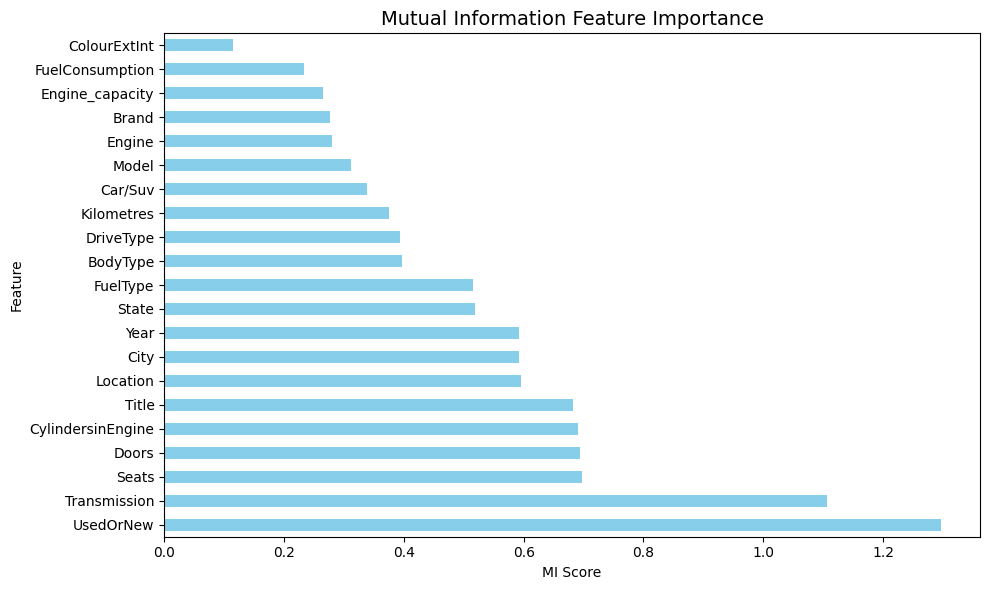

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Calculating mi scores
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X.fillna(0, inplace=True)

mi = mutual_info_classif(X, y,random_state=50)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Plotting mi scores
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh', color='skyblue')
plt.title("Mutual Information Feature Importance", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Return to original x and y
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']


# Data splitting into training and validation data

In [ ]:
from sklearn.model_selection import KFold, train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=50)

# Mean encoding for 'Model' as it contrains a large number of different categories

target_col = 'Model'

X_train_te = X_train_full.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=50)
target_means = pd.Series(index=X_train_te.index, dtype='float64')


for train_index,val_index in kf.split(X_train_te):
    X_tr, X_val = X_train_te.iloc[train_index], X_train_te.iloc[val_index]

    y_tr=y_train.iloc[train_index]

    means=y_tr.groupby(X_tr[target_col]).mean()
    target_means.iloc[val_index] = X_val[target_col].map(means)

target_means.fillna(y_train.mean(), inplace=True)

X_train_full_enc = X_train_full.copy()
X_train_full_enc[target_col+'_enc']=target_means
X_train_full_enc.drop(columns=[target_col], inplace=True)


means_full = y_train.groupby(X_train_full[target_col]).mean()

X_valid_full_enc = X_valid_full.copy()
X_valid_full_enc[target_col + '_enc'] = X_valid_full[target_col].map(means_full).fillna(y_train.mean())
X_valid_full_enc.drop(columns=[target_col], inplace=True)

Test_data_enc = Test_data.copy()
Test_data_enc[target_col + '_enc'] = Test_data[target_col].map(means_full).fillna(y_train.mean())
Test_data_enc.drop(columns=[target_col], inplace=True)

In [ ]:
# unique values in each column
print('Unique values in each column','\n', (pd.concat([X_train_full_enc, X_valid_full_enc, Test_data_enc], ignore_index=True)).nunique())

Unique values in each column 
 Brand                   76
Year                    45
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Engine_capacity         65
City                   606
State                    9
Model_enc             2213
Price                  579
dtype: int64


# Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import joblib


categorical_cols = [cname for cname in X_train_full_enc.columns if
                    X_train_full_enc[cname].nunique() <= 76 and
                    (X_train_full_enc[cname].dtype == "object" or X_train_full_enc[cname].dtype.name == "category")]

numerical_cols = [cname for cname in X_train_full_enc.columns if
                  X_train_full_enc[cname].dtype in ['int64', 'float64']]

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)])

print(X_train_full_enc.columns)
X_train_pre = preprocessor.fit_transform(X_train_full_enc)
X_valid_pre = preprocessor.transform(X_valid_full_enc)
X_test_pre = preprocessor.transform(Test_data_enc)


# for reuse
Test_data_enc.to_csv("Test_data_enc.csv", index=False)
joblib.dump(preprocessor, "preprocessor.pkl")

Index(['Brand', 'Year', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission',
       'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres',
       'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors',
       'Seats', 'Engine_capacity', 'City', 'State', 'Model_enc'],
      dtype='object')


['preprocessor.pkl']

In [ ]:
# unique values in each column
print('Unique values in each column','\n', (pd.concat([X_train_full_enc, X_valid_full_enc, Test_data_enc], ignore_index=True)).nunique())

Unique values in each column 
 Brand                   76
Year                    45
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Engine_capacity         65
City                   606
State                    9
Model_enc             2213
Price                  579
dtype: int64


In [ ]:
num_features = numerical_cols

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)

feature_names = list(num_features) + list(cat_features)
print(feature_names)

['Year', 'FuelConsumption', 'Kilometres', 'Doors', 'Seats', 'Engine_capacity', 'Model_enc', 'Brand_Abarth', 'Brand_Alfa', 'Brand_Aston', 'Brand_Audi', 'Brand_BMW', 'Brand_BYD', 'Brand_Bentley', 'Brand_Caterham', 'Brand_Chery', 'Brand_Chevrolet', 'Brand_Chrysler', 'Brand_Citroen', 'Brand_Cupra', 'Brand_Daihatsu', 'Brand_Dodge', 'Brand_FPV', 'Brand_Ferrari', 'Brand_Fiat', 'Brand_Ford', 'Brand_Foton', 'Brand_GWM', 'Brand_Geely', 'Brand_Genesis', 'Brand_Great', 'Brand_HSV', 'Brand_Haval', 'Brand_Hino', 'Brand_Holden', 'Brand_Honda', 'Brand_Hummer', 'Brand_Hyundai', 'Brand_Ineos', 'Brand_Infiniti', 'Brand_International', 'Brand_Isuzu', 'Brand_Iveco', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Kia', 'Brand_LDV', 'Brand_Lamborghini', 'Brand_Land', 'Brand_Lexus', 'Brand_Lotus', 'Brand_MG', 'Brand_Mahindra', 'Brand_Maserati', 'Brand_Mazda', 'Brand_McLaren', 'Brand_Mercedes-Benz', 'Brand_Mini', 'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand

# Tensorflow neural network

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, initializers

import optuna
from optuna.samplers import CmaEsSampler, RandomSampler
from optuna.integration import TensorBoardCallback

set_seed(50)

def create_model(units, num_layers):
    set_seed(50)
    seed=50
    model=keras.Sequential()

    for i in range(num_layers):
        model.add(layers.Dense(units*2**(num_layers-(i+1)),kernel_initializer=initializers.RandomNormal(seed+i)))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1,kernel_initializer=initializers.RandomNormal(seed)))


    return model

# Hyperparameter tuning

In [ ]:
global total_epochs
total_epochs=400

set_seed(50)

def objective(trial):
  set_seed(50)
  global model, best_model, best_val_loss
  tf.random.set_seed(50)

  batch_size = trial.suggest_int('batch_size', 500, 1000)
  units=trial.suggest_int('units', 110, 200)
  num_layers=trial.suggest_int('num_layers', 2, 4)

  model = create_model(units, num_layers)

  optimizer=keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate',0.001,0.01))
  model.compile(optimizer=optimizer,loss='mae', metrics=['mae'])

  # logging data to tensorboard
  log_dir = f"logs_{timestamp}/fit/Trial_{trial.number}"
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=True)


  early_stopping = EarlyStopping(
  min_delta=10, # minimium amount of change to count as an improvement
  patience=20, # how many epochs to wait before stopping
  restore_best_weights=True,)


  history = model.fit(
  X_train_pre, y_train,
  validation_data=(X_valid_pre, y_valid),
  batch_size=batch_size,
  epochs=total_epochs,
  callbacks=[early_stopping,tensorboard_callback],
  shuffle=False
  )

  val_loss = history.history['val_loss'][-1]

  # --- Custom Scalars for Hyperparameters & Objective ---
  writer = tf.summary.create_file_writer(log_dir)
  with writer.as_default():
      tf.summary.scalar('Parameters/Num_layers', len(model.layers), step=trial.number)

      for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Dense):
          tf.summary.scalar(f'Parameters/Units_{i}', layer.units, step=trial.number)
      tf.summary.scalar('Parameters/Batch_size', batch_size, step=trial.number)
      tf.summary.scalar('Metrics/Val_loss', val_loss, step=trial.number)

  writer.close()

  return val_loss



In [ ]:
set_seed(50)

study=optuna.create_study(study_name='Hyperparameter Optimization',direction='minimize', sampler=RandomSampler(seed=50))
study.optimize(objective,n_trials=20)

[I 2025-08-05 11:48:08,277] A new study created in memory with name: Hyperparameter Optimization


Epoch 1/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 34989.5742 - mae: 34989.5781 - val_loss: 2546540.7500 - val_mae: 2546541.0000
Epoch 2/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 34677.0391 - mae: 34677.0391 - val_loss: 1199725.0000 - val_mae: 1199725.0000
Epoch 3/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 34356.5820 - mae: 34356.5820 - val_loss: 723699.1875 - val_mae: 723699.1875
Epoch 4/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 33984.5508 - mae: 33984.5508 - val_loss: 475415.3125 - val_mae: 475415.3125
Epoch 5/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 33592.1797 - mae: 33592.1797 - val_loss: 321752.7812 - val_mae: 321752.7812
Epoch 6/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 33117.3359 - mae: 33117.3359 - val_loss: 220207.9219 - val_mae: 220207.9219
Epoch 7/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 32656.2344 - mae: 32656.2344 - val_loss: 149983.3281 - val_mae: 149983.3125
Epoch 8/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43

[I 2025-08-05 11:53:47,072] Trial 0 finished with value: 7622.5166015625 and parameters: {'batch_size': 747, 'units': 130, 'num_layers': 2, 'learning_rate': 0.004566969187504993}. Best is trial 0 with value: 7622.5166015625.


Epoch 1/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 34846.9492 - mae: 34846.9492 - val_loss: 10294311.0000 - val_mae: 10294311.0000
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 34157.9375 - mae: 34157.9375 - val_loss: 3212849.0000 - val_mae: 3212849.0000
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 33254.3750 - mae: 33254.3750 - val_loss: 1306254.2500 - val_mae: 1306254.2500
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 31986.0234 - mae: 31986.0254 - val_loss: 549040.6250 - val_mae: 549040.6250
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 30618.6074 - mae: 30618.6074 - val_loss: 236147.2188 - val_mae: 236147.2188
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 29065.2422 - mae: 29065.2422 - val_loss: 85466.2109 - val_mae: 85466.2109
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 27117.3730 - mae: 27117.3730 - val_loss: 30693.4766 - val_mae: 30693.4766
Epoch 8/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 9

[I 2025-08-05 12:50:02,890] Trial 1 finished with value: 6901.8798828125 and parameters: {'batch_size': 689, 'units': 200, 'num_layers': 3, 'learning_rate': 0.007947045953557424}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 35288.6016 - mae: 35288.6016 - val_loss: 10130783.0000 - val_mae: 10130783.0000
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 35060.2578 - mae: 35060.2578 - val_loss: 3507205.5000 - val_mae: 3507205.5000
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 34806.7578 - mae: 34806.7578 - val_loss: 1804231.6250 - val_mae: 1804231.6250
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 34524.3125 - mae: 34524.3125 - val_loss: 1070526.2500 - val_mae: 1070526.2500
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 34222.7617 - mae: 34222.7617 - val_loss: 674623.8750 - val_mae: 674623.8750
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 33851.1562 - mae: 33851.1562 - val_loss: 434123.9688 - val_mae: 434123.9688
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 33405.7930 - mae: 33405.7930 - val_loss: 279558.7188 - val_mae: 279558.6875
Epoch 8/400
15/15 ━━━━━━━━━━━━━━━━━━━

[I 2025-08-05 12:50:44,348] Trial 2 finished with value: 20612.173828125 and parameters: {'batch_size': 881, 'units': 138, 'num_layers': 3, 'learning_rate': 0.004165883357469062}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 35248.8359 - mae: 35248.8359 - val_loss: 20373814.0000 - val_mae: 20373812.0000
Epoch 2/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 34705.2461 - mae: 34705.2461 - val_loss: 4619571.0000 - val_mae: 4619571.0000
Epoch 3/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 33926.1523 - mae: 33926.1523 - val_loss: 1564954.5000 - val_mae: 1564954.5000
Epoch 4/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 32736.3809 - mae: 32736.3809 - val_loss: 563944.3125 - val_mae: 563944.3125
Epoch 5/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 31317.1523 - mae: 31317.1523 - val_loss: 227262.5781 - val_mae: 227262.5781
Epoch 6/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 29885.3320 - mae: 29885.3320 - val_loss: 86420.3281 - val_mae: 86420.3281
Epoch 7/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 28196.0996 - mae: 28196.0996 - val_loss: 31200.0684 - val_mae: 31200.0664
Epoch 8/400
22/22 ━━━━━━━━━━━━━━━━━━━

[I 2025-08-05 14:23:47,894] Trial 3 finished with value: 6934.40283203125 and parameters: {'batch_size': 572, 'units': 198, 'num_layers': 4, 'learning_rate': 0.006039613933499126}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 35271.4023 - mae: 35271.4023 - val_loss: 24018874.0000 - val_mae: 24018874.0000
Epoch 2/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 34932.2930 - mae: 34932.2930 - val_loss: 5841116.0000 - val_mae: 5841116.0000
Epoch 3/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - loss: 34513.9883 - mae: 34513.9883 - val_loss: 2353123.2500 - val_mae: 2353123.2500
Epoch 4/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 33972.6562 - mae: 33972.6562 - val_loss: 1099844.2500 - val_mae: 1099844.2500
Epoch 5/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 33223.1523 - mae: 33223.1523 - val_loss: 530373.5625 - val_mae: 530373.5625
Epoch 6/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 32287.5742 - mae: 32287.5742 - val_loss: 269421.1875 - val_mae: 269421.1875
Epoch 7/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 31379.4316 - mae: 31379.4316 - val_loss: 145647.6094 - val_mae: 145647.6094
Epoch 8/400
20/20 ━━━━━━━━━━━━

[I 2025-08-05 14:52:29,121] Trial 4 finished with value: 7493.94140625 and parameters: {'batch_size': 657, 'units': 190, 'num_layers': 4, 'learning_rate': 0.004519787028747055}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 35390.2109 - mae: 35390.2148 - val_loss: 27804662.0000 - val_mae: 27804662.0000
Epoch 2/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 35029.5781 - mae: 35029.5820 - val_loss: 6778317.5000 - val_mae: 6778317.5000
Epoch 3/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 34517.7539 - mae: 34517.7539 - val_loss: 2636055.0000 - val_mae: 2636055.0000
Epoch 4/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 33862.7578 - mae: 33862.7578 - val_loss: 1149726.5000 - val_mae: 1149726.5000
Epoch 5/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 32926.4688 - mae: 32926.4648 - val_loss: 523176.9688 - val_mae: 523176.9688
Epoch 6/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 31961.1484 - mae: 31961.1484 - val_loss: 265674.7188 - val_mae: 265674.7188
Epoch 7/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 31127.0879 - mae: 31127.0879 - val_loss: 142550.8125 - val_mae: 142550.8125
Epoch 8/400
17/17 ━━━━━━━━━━━━

[I 2025-08-05 15:14:40,314] Trial 5 finished with value: 7060.60205078125 and parameters: {'batch_size': 754, 'units': 157, 'num_layers': 4, 'learning_rate': 0.00614235762135034}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 35311.8789 - mae: 35311.8789 - val_loss: 2281204.5000 - val_mae: 2281204.5000
Epoch 2/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 35218.4180 - mae: 35218.4180 - val_loss: 1058652.8750 - val_mae: 1058652.8750
Epoch 3/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 35131.6289 - mae: 35131.6289 - val_loss: 645432.8125 - val_mae: 645432.8125
Epoch 4/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 35042.9180 - mae: 35042.9180 - val_loss: 438329.1562 - val_mae: 438329.1562
Epoch 5/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 34950.3398 - mae: 34950.3359 - val_loss: 314449.5938 - val_mae: 314449.5938
Epoch 6/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 34853.1992 - mae: 34853.1992 - val_loss: 233416.0156 - val_mae: 233416.0156
Epoch 7/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 34753.1953 - mae: 34753.1953 - val_loss: 176202.8438 - val_mae: 176202.8438
Epoch 8/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33

[I 2025-08-05 15:15:08,655] Trial 6 finished with value: 29881.7265625 and parameters: {'batch_size': 834, 'units': 114, 'num_layers': 2, 'learning_rate': 0.001507614752543441}. Best is trial 1 with value: 6901.8798828125.


Epoch 1/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - loss: 35180.2891 - mae: 35180.2930 - val_loss: 20064920.0000 - val_mae: 20064920.0000
Epoch 2/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 34496.8555 - mae: 34496.8555 - val_loss: 4255690.0000 - val_mae: 4255690.0000
Epoch 3/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 33416.3203 - mae: 33416.3203 - val_loss: 1252765.0000 - val_mae: 1252765.0000
Epoch 4/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 31803.1699 - mae: 31803.1699 - val_loss: 420653.0938 - val_mae: 420653.0938
Epoch 5/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 30155.0234 - mae: 30155.0234 - val_loss: 140249.4375 - val_mae: 140249.4375
Epoch 6/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 28195.7344 - mae: 28195.7344 - val_loss: 40565.4961 - val_mae: 40565.4961
Epoch 7/400
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 25791.5801 - mae: 25791.5801 - val_loss: 19731.7051 - val_mae: 19731.7051
Epoch 8/400
22/22 ━━━━━━━━━━━━━━━━━━

[I 2025-08-05 15:43:18,933] Trial 7 finished with value: 6887.72509765625 and parameters: {'batch_size': 590, 'units': 194, 'num_layers': 4, 'learning_rate': 0.007426834366906844}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 35464.8438 - mae: 35464.8438 - val_loss: 34267764.0000 - val_mae: 34267764.0000
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 35222.4961 - mae: 35222.4961 - val_loss: 8591877.0000 - val_mae: 8591877.0000
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 34934.5312 - mae: 34934.5312 - val_loss: 3646305.0000 - val_mae: 3646305.0000
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 34581.8125 - mae: 34581.8086 - val_loss: 1860610.1250 - val_mae: 1860610.1250
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 34165.5234 - mae: 34165.5234 - val_loss: 1016423.3750 - val_mae: 1016423.3750
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 33599.0039 - mae: 33599.0000 - val_loss: 560902.8750 - val_mae: 560902.8750
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 32946.4531 - mae: 32946.4531 - val_loss: 318202.5938 - val_mae: 318202.5938
Epoch 8/400
15/15 ━━━━━━━━━━━

[I 2025-08-05 15:44:23,397] Trial 8 finished with value: 19557.359375 and parameters: {'batch_size': 867, 'units': 152, 'num_layers': 4, 'learning_rate': 0.004657782190067268}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 35139.8164 - mae: 35139.8164 - val_loss: 12245483.0000 - val_mae: 12245483.0000
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 34975.7500 - mae: 34975.7500 - val_loss: 4236836.0000 - val_mae: 4236836.0000
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 34778.3945 - mae: 34778.3945 - val_loss: 2204046.2500 - val_mae: 2204046.2500
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 34574.1367 - mae: 34574.1367 - val_loss: 1337105.7500 - val_mae: 1337105.7500
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 34365.8906 - mae: 34365.8906 - val_loss: 874432.0000 - val_mae: 874432.0000
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 34125.9375 - mae: 34125.9375 - val_loss: 595006.0000 - val_mae: 595006.0000
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 33843.9961 - mae: 33843.9961 - val_loss: 411628.9062 - val_mae: 411628.9062
Epoch 8/400
15/15 ━━━━━━━━━━━━━━━━━━━━

[I 2025-08-05 15:44:57,129] Trial 9 finished with value: 21175.373046875 and parameters: {'batch_size': 842, 'units': 169, 'num_layers': 3, 'learning_rate': 0.0029983545287170827}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 35340.4688 - mae: 35340.4688 - val_loss: 42257248.0000 - val_mae: 42257248.0000
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 35072.0352 - mae: 35072.0352 - val_loss: 10502820.0000 - val_mae: 10502820.0000
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 34754.9258 - mae: 34754.9219 - val_loss: 4385752.5000 - val_mae: 4385752.5000
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 34369.9062 - mae: 34369.9062 - val_loss: 2178315.0000 - val_mae: 2178315.2500
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 33856.1094 - mae: 33856.1094 - val_loss: 1155188.5000 - val_mae: 1155188.3750
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 33164.0508 - mae: 33164.0508 - val_loss: 614795.6250 - val_mae: 614795.5625
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 32356.2715 - mae: 32356.2715 - val_loss: 341304.2812 - val_mae: 341304.2812
Epoch 8/400
15/15 ━━━━━━━━━

[I 2025-08-05 16:03:39,362] Trial 10 finished with value: 7331.9111328125 and parameters: {'batch_size': 841, 'units': 189, 'num_layers': 4, 'learning_rate': 0.004888020230182729}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 35390.6523 - mae: 35390.6523 - val_loss: 46047136.0000 - val_mae: 46047136.0000
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 35275.3008 - mae: 35275.3008 - val_loss: 11660714.0000 - val_mae: 11660714.0000
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 35164.2773 - mae: 35164.2773 - val_loss: 5158721.5000 - val_mae: 5158721.5000
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 35056.8281 - mae: 35056.8281 - val_loss: 2844444.5000 - val_mae: 2844444.5000
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 34946.2656 - mae: 34946.2656 - val_loss: 1763222.7500 - val_mae: 1763222.7500
Epoch 6/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 34802.5039 - mae: 34802.5039 - val_loss: 1170605.3750 - val_mae: 1170605.3750
Epoch 7/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 34643.3906 - mae: 34643.3906 - val_loss: 810551.9375 - val_mae: 810551.9375
Epoch 8/400
14/14 ━━━━━━━

[I 2025-08-05 16:05:22,428] Trial 11 finished with value: 22616.958984375 and parameters: {'batch_size': 959, 'units': 181, 'num_layers': 4, 'learning_rate': 0.002123692241406335}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 34887.8047 - mae: 34887.8047 - val_loss: 3540695.5000 - val_mae: 3540695.5000
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 34490.9219 - mae: 34490.9219 - val_loss: 1704528.3750 - val_mae: 1704528.3750
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 34077.9766 - mae: 34077.9766 - val_loss: 1053563.7500 - val_mae: 1053563.7500
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 33595.6953 - mae: 33595.6953 - val_loss: 705325.2500 - val_mae: 705325.2500
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 33083.6055 - mae: 33083.6055 - val_loss: 485299.7188 - val_mae: 485299.7188
Epoch 6/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 32508.0898 - mae: 32508.0898 - val_loss: 335182.5625 - val_mae: 335182.5625
Epoch 7/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 31950.3770 - mae: 31950.3770 - val_loss: 231183.1875 - val_mae: 231183.1875
Epoch 8/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-08-05 16:08:09,125] Trial 12 finished with value: 7721.2021484375 and parameters: {'batch_size': 959, 'units': 145, 'num_layers': 2, 'learning_rate': 0.006550582732502629}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 35524.8594 - mae: 35524.8594 - val_loss: 20722242.0000 - val_mae: 20722242.0000
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 35376.1172 - mae: 35376.1133 - val_loss: 5220880.5000 - val_mae: 5220880.5000
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 35207.5078 - mae: 35207.5078 - val_loss: 2272381.0000 - val_mae: 2272381.0000
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 35023.0234 - mae: 35023.0234 - val_loss: 1221348.1250 - val_mae: 1221348.1250
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 34830.5703 - mae: 34830.5703 - val_loss: 723338.6250 - val_mae: 723338.6250
Epoch 6/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 34568.6133 - mae: 34568.6133 - val_loss: 450211.1875 - val_mae: 450211.1875
Epoch 7/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 34277.0664 - mae: 34277.0664 - val_loss: 287548.2188 - val_mae: 287548.2188
Epoch 8/400
18/18 ━━━━━━━━━━━━━━━━━

[I 2025-08-05 16:09:21,083] Trial 13 finished with value: 23137.876953125 and parameters: {'batch_size': 734, 'units': 133, 'num_layers': 4, 'learning_rate': 0.002607572821237106}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 35105.3242 - mae: 35105.3242 - val_loss: 7331297.5000 - val_mae: 7331297.5000
Epoch 2/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 34983.9805 - mae: 34983.9766 - val_loss: 2458546.7500 - val_mae: 2458547.0000
Epoch 3/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 34844.6367 - mae: 34844.6367 - val_loss: 1243384.6250 - val_mae: 1243384.6250
Epoch 4/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 34688.7500 - mae: 34688.7500 - val_loss: 733901.6250 - val_mae: 733901.6250
Epoch 5/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 34534.4453 - mae: 34534.4453 - val_loss: 468052.9375 - val_mae: 468052.9375
Epoch 6/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 34362.3047 - mae: 34362.3047 - val_loss: 310979.1250 - val_mae: 310979.1562
Epoch 7/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 34169.5430 - mae: 34169.5430 - val_loss: 211141.5469 - val_mae: 211141.5469
Epoch 8/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-08-05 16:10:03,721] Trial 14 finished with value: 24384.9921875 and parameters: {'batch_size': 613, 'units': 170, 'num_layers': 3, 'learning_rate': 0.0016610260810393262}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 35399.9531 - mae: 35399.9531 - val_loss: 4626205.5000 - val_mae: 4626206.0000
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 34908.4844 - mae: 34908.4844 - val_loss: 1504164.3750 - val_mae: 1504164.3750
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 34307.7656 - mae: 34307.7656 - val_loss: 677157.5625 - val_mae: 677157.5625
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 33515.2617 - mae: 33515.2617 - val_loss: 322440.6562 - val_mae: 322440.6562
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 32620.8574 - mae: 32620.8574 - val_loss: 170533.2812 - val_mae: 170533.2812
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 31803.4902 - mae: 31803.4902 - val_loss: 91476.6953 - val_mae: 91476.6953
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 30993.1680 - mae: 30993.1680 - val_loss: 48111.0625 - val_mae: 48111.0625
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/s

[I 2025-08-05 16:15:50,680] Trial 15 finished with value: 7080.1630859375 and parameters: {'batch_size': 569, 'units': 120, 'num_layers': 3, 'learning_rate': 0.005862666063433797}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 35098.6953 - mae: 35098.6953 - val_loss: 15096744.0000 - val_mae: 15096744.0000
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 34596.9805 - mae: 34596.9805 - val_loss: 5078808.0000 - val_mae: 5078808.0000
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 33981.4180 - mae: 33981.4180 - val_loss: 2372243.5000 - val_mae: 2372243.5000
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 33169.5078 - mae: 33169.5078 - val_loss: 1177955.3750 - val_mae: 1177955.3750
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 32194.4004 - mae: 32194.4004 - val_loss: 606221.9375 - val_mae: 606221.9375
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 31268.7363 - mae: 31268.7363 - val_loss: 332580.0938 - val_mae: 332580.0938
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 30343.4434 - mae: 30343.4434 - val_loss: 168521.9531 - val_mae: 168521.9531
Epoch 8/400
13/13 ━━━━━━━━━━━━━━━━━

[I 2025-08-05 16:20:38,306] Trial 16 finished with value: 7232.52783203125 and parameters: {'batch_size': 979, 'units': 163, 'num_layers': 3, 'learning_rate': 0.009300364199601893}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 35514.6758 - mae: 35514.6758 - val_loss: 34398168.0000 - val_mae: 34398168.0000
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 35012.9961 - mae: 35012.9961 - val_loss: 8195708.5000 - val_mae: 8195708.5000
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 34377.8672 - mae: 34377.8672 - val_loss: 3013672.5000 - val_mae: 3013672.5000
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 33453.2500 - mae: 33453.2500 - val_loss: 1223602.6250 - val_mae: 1223602.6250
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 32419.5410 - mae: 32419.5410 - val_loss: 574378.3125 - val_mae: 574378.3125
Epoch 6/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 31508.3945 - mae: 31508.3945 - val_loss: 296996.7500 - val_mae: 296996.7500
Epoch 7/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 30613.3438 - mae: 30613.3438 - val_loss: 155605.9688 - val_mae: 155605.9688
Epoch 8/400
14/14 ━━━━━━━━━━━━━

[I 2025-08-05 16:22:04,297] Trial 17 finished with value: 14087.6943359375 and parameters: {'batch_size': 960, 'units': 132, 'num_layers': 4, 'learning_rate': 0.009678485067415626}. Best is trial 7 with value: 6887.72509765625.


Epoch 1/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 35222.7227 - mae: 35222.7227 - val_loss: 20136092.0000 - val_mae: 20136092.0000
Epoch 2/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 34353.2031 - mae: 34353.2031 - val_loss: 3943966.2500 - val_mae: 3943966.2500
Epoch 3/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 32909.5234 - mae: 32909.5234 - val_loss: 1019567.5000 - val_mae: 1019567.5000
Epoch 4/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 31127.7383 - mae: 31127.7383 - val_loss: 321692.3125 - val_mae: 321692.3125
Epoch 5/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 29356.3516 - mae: 29356.3516 - val_loss: 90253.5938 - val_mae: 90253.5938
Epoch 6/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 27212.7207 - mae: 27212.7207 - val_loss: 26698.8750 - val_mae: 26698.8750
Epoch 7/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 24814.5371 - mae: 24814.5391 - val_loss: 19128.7363 - val_mae: 19128.7363
Epoch 8/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-08-05 21:45:25,378] Trial 18 finished with value: 6551.2548828125 and parameters: {'batch_size': 613, 'units': 175, 'num_layers': 4, 'learning_rate': 0.009430760796829397}. Best is trial 18 with value: 6551.2548828125.


Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - loss: 34930.0117 - mae: 34930.0117 - val_loss: 3446748.0000 - val_mae: 3446748.0000
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 34856.7812 - mae: 34856.7812 - val_loss: 1622916.8750 - val_mae: 1622916.8750
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 34790.6484 - mae: 34790.6484 - val_loss: 1004740.0625 - val_mae: 1004740.0625
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 34699.5195 - mae: 34699.5195 - val_loss: 694804.5625 - val_mae: 694804.5625
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 34622.7461 - mae: 34622.7461 - val_loss: 508967.3750 - val_mae: 508967.3750
Epoch 6/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 34539.0156 - mae: 34539.0156 - val_loss: 385692.2188 - val_mae: 385692.2188
Epoch 7/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 34462.8477 - mae: 34462.8477 - val_loss: 298911.2812 - val_mae: 298911.2812
Epoch 8/400
14/14 ━━━━━━━━━━━━━━━━

[I 2025-08-05 21:47:00,165] Trial 19 finished with value: 29096.013671875 and parameters: {'batch_size': 927, 'units': 148, 'num_layers': 2, 'learning_rate': 0.0013137879590326633}. Best is trial 18 with value: 6551.2548828125.


In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

Best hyperparameters: {'batch_size': 613, 'units': 175, 'num_layers': 4, 'learning_rate': 0.009430760796829397}
Best validation loss: 6551.2548828125


# Building the model with tuned hyperparameters

In [ ]:
seed=50
set_seed(50)


num_layers=study.best_params['num_layers']
units=study.best_params['units']
best_model= create_model(units, num_layers)

optimizer=keras.optimizers.Adam(study.best_params['learning_rate'])
best_model.compile(optimizer=optimizer,loss='mae', metrics=['mae'])


# Fit the model
best_model.fit(
    X_train_pre, y_train,
    validation_data=(X_valid_pre, y_valid),
    batch_size=study.best_params['batch_size'],
    epochs=total_epochs,
    shuffle=False,
    callbacks=[EarlyStopping(min_delta=10, patience=20, restore_best_weights=True)]
)

Epoch 1/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - loss: 35222.7227 - mae: 35222.7227 - val_loss: 20136092.0000 - val_mae: 20136092.0000
Epoch 2/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - loss: 34353.2031 - mae: 34353.2031 - val_loss: 3943966.2500 - val_mae: 3943966.2500
Epoch 3/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - loss: 32909.5234 - mae: 32909.5234 - val_loss: 1019567.5000 - val_mae: 1019567.5000
Epoch 4/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - loss: 31127.7383 - mae: 31127.7383 - val_loss: 321692.3125 - val_mae: 321692.3125
Epoch 5/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - loss: 29356.3516 - mae: 29356.3516 - val_loss: 90253.5938 - val_mae: 90253.5938
Epoch 6/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 469ms/step - loss: 27212.7207 - mae: 27212.7207 - val_loss: 26698.8750 - val_mae: 26698.8750
Epoch 7/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - loss: 24814.5371 - mae: 24814.5391 - val_loss: 19128.7363 - val_mae: 19128.7363
Epoch 8/400
21/21 ━━━━━━━━━━━━━━━

# Save the tensorflow model

In [ ]:
best_model.save("best_model_complete_tf.keras")

import json

metadata = {
    'best_params': study.best_params
}

with open('best_model_complete_tf_metadata.json', 'w') as f:
    json.dump(metadata, f)

# Predicting on test data

In [ ]:
y_pred_test = best_model.predict(X_test_pre)
y_pred_test = y_pred_test.flatten()
Prediction=pd.Series(y_pred_test.tolist())
Prediction.name = 'Predicted Price'
Prediction=pd.DataFrame(Prediction)
Prediction['Predicted Price'] = Prediction['Predicted Price'].astype(int)
print(Prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
     Predicted Price
0               8000
1              27061
2              15133
3              19914
4              29611
..               ...
995            44180
996            40095
997            33091
998            37583
999            56203

[1000 rows x 1 columns]


# Creating output file in form of CSV

In [ ]:
from sklearn.metrics import mean_absolute_error

y_actual_test.name = 'Actual Price'
y_actual_test=pd.DataFrame(y_actual_test)

Final_output = complete_data_original_columns.tail(1000).copy()
Final_output['Predicted Price']=Prediction['Predicted Price'].values
mae = mean_absolute_error(y_actual_test, y_pred_test)
print(f"Test MAE: {mae:.4f}")
Final_output.to_csv('Final_results.csv', index=True)

Test MAE: 8863.6768


# Tensorboard plots for results

In [ ]:
import shap
import matplotlib.pyplot as plt
import io
from io import BytesIO
from PIL import Image

def plot_to_image(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    buf.seek(0)
    image = Image.open(buf).convert('RGB')
    image = np.array(image)
    image = np.expand_dims(image, 0)
    return image


def plot_pred_vs_actual(y_actual_test, y_pred_test):
    plt.figure(figsize=(6, 4), dpi=150)
    plt.scatter(y_actual_test, y_pred_test, alpha=0.6)
    plt.plot([y_actual_test.min(), y_actual_test.max()], [y_actual_test.min(), y_actual_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    return plt.gcf()


def plot_residuals(y_actual_test, y_pred_test):
    residuals = y_pred_test - y_actual_test
    plt.figure(figsize=(6, 4), dpi=150)
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.hlines(0, min(y_pred_test), max(y_pred_test), colors='red', linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    return plt.gcf()



fig1 = plot_pred_vs_actual(y_actual_test['Actual Price'].values, y_pred_test.tolist())
image1 = plot_to_image(fig1)
plt.close(fig1)

fig2 = plot_residuals(y_actual_test['Actual Price'].values, y_pred_test.tolist())
image2 = plot_to_image(fig2)
plt.close(fig2)


explainer = shap.Explainer(model, X_train_pre.toarray())  # model is your tf.keras.Model, X_train_np is numpy
shap_values = explainer(X_test_pre.toarray())

# Step 2: Generate SHAP summary plot (don't show it)
plt.figure(dpi=150)
shap.summary_plot(shap_values.values, X_test_pre.toarray(), feature_names=feature_names, max_display=40, show=False)
fig3 = plt.gcf()
image3 = plot_to_image(fig3)
plt.close(fig3)


log_dir = f"logs_{timestamp}/Predictions"
writer = tf.summary.create_file_writer(log_dir)

with writer.as_default():


    tf.summary.image("Predicted vs Actual", image1, step=0)
    tf.summary.image("Residual vs Predicted", image2, step=0)
    tf.summary.image("SHAP Summary", image3, step=0)

writer.close()


PermutationExplainer explainer: 1001it [05:16,  3.16it/s]                          
C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_24168\1631352354.py:54: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_pre.toarray(), feature_names=feature_names, max_display=40, show=False)


# Model parameters summary

In [ ]:
best_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_86 (Dense)                │ (None, 1400)           │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 1400)           │         5,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_66 (ReLU)                 │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 700)            │       980,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 700)            │         2,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_67 (ReLU)                 │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 350)            │       245,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 350)            │         1,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_68 (ReLU)                 │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 175)            │        61,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 175)            │           700 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_69 (ReLU)                 │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,425,755 (16.88 MB)

 Trainable params: 1,473,501 (5.62 MB)

 Non-trainable params: 5,250 (20.51 KB)

 Optimizer params: 2,947,004 (11.24 MB)

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir logs_20250729-134721